In [ ]:
#!pip install scipy
#!pip3 uninstall scikit-learn --yes
#!pip3 install scikit-learn==0.22
#!pip install iterative-stratification

In [10]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import json
import os
from operator import add

## Classification

In [11]:
annos_path = 'pure_pseudo.json'
with open(annos_path, 'rt', encoding='UTF-8') as annotations:
        coco = json.load(annotations)
        info = coco['info']
        licenses = coco['licenses']
        images = coco['images']
        annotations = coco['annotations']
        categories = coco['categories']

X = coco['images']
Y = [ [0]*len(categories) for _ in range(len(images))]

for anno in annotations:
    image_id = anno['image_id']
    try:
        Y[image_id][anno['category_id']]+=1
    except:
        print(image_id, anno['category_id'])


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1010)


imgid2annos = [[] for _ in range(len(coco['images']))]
for anno in annotations:
    imgid = anno['image_id']
    imgid2annos[imgid].append(anno)


os.makedirs('./pseudo_kfold',exist_ok=True)
root = './pseudo_kfold'

label_nums =np.array([[0]*len(categories) for _ in range(5)]) # for visualization
image_nums = np.array([0]*5) # for visualization

for idx,(train_index, val_index) in enumerate(mskf.split(X, Y)):
    cv_train_path = os.path.join(root,f'cv_pseudo_train{idx+1}.json')
    cv_train = dict()

    # train
    cv_train['info'] = coco['info']
    cv_train['licenses'] = coco['licenses']
    cv_train['categories'] = coco['categories']
    
    train_images=[]
    train_annos=[]
    for t_index in train_index:
        train_images.append(X[t_index])
        image_id = X[t_index]['id']
        train_annos +=imgid2annos[image_id]
        
        # for visualization
        label_nums[idx] = list(map(add,label_nums[idx],Y[t_index]))
    image_nums[idx] +=len(train_index)

    
    cv_train['images'] = train_images
    cv_train['annotations'] = train_annos
    
    with open(cv_train_path,'w') as f:
        json.dump(cv_train,f)
    

## Result visualization

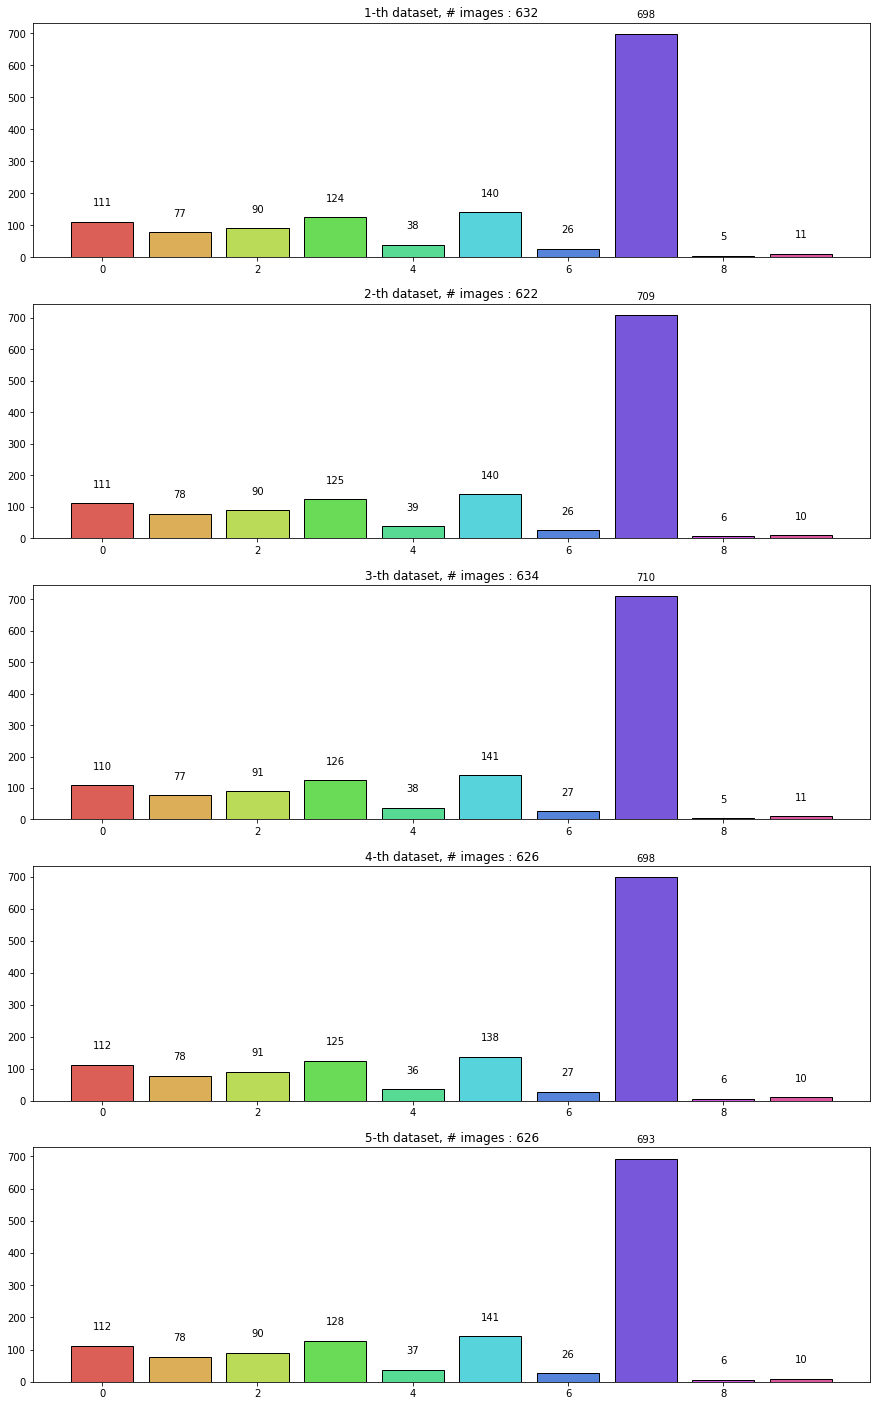

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,axes = plt.subplots(5,1,figsize=(15,25))
axes = axes.flatten()
colors = sns.color_palette('hls',10) 

for idx,ax in enumerate(axes):
    ax.set_title(f'{idx+1}-th dataset, # images : {image_nums[idx]}')
    line =ax.bar(list(range(10)),height=label_nums[idx],edgecolor='black',color=colors)
    for label_idx,label_value in enumerate(label_nums[idx]):
        ax.text(label_idx,label_value+50,label_value,ha='center')
#     sns.barplot(x=list(range(10)),y=label_nums[idx],ax=ax,hue=[d['name'] for d in coco['categories']])

#label_nums